# **Import Libraries and Set Up Environment for Model Training**

In [1]:
!pip install keras-tuner --quiet
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, mixed_precision
mixed_precision.set_global_policy("mixed_float16")
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# **Data Preparation and Feature Engineering for Modeling**

In [2]:
df = pd.read_csv("/content/drive/MyDrive/final_dataset.csv").sort_values(["match_id", "t"]).fillna(0)

target_cols = ["y_baron_10","y_baron_20","y_baron_30",
               "y_dragon_10","y_dragon_20","y_dragon_30",
               "y_teamfight_10","y_teamfight_20","y_teamfight_30"]

exclude_cols = ["match_id", "t"] + target_cols
feature_cols = [c for c in df.columns if c not in exclude_cols]
for c in feature_cols:
    df[f"{c}_diff"] = df.groupby("match_id")[c].diff().fillna(0)
feature_cols = [c for c in df.columns if c not in exclude_cols]
scaler = StandardScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])
print("Features:", len(feature_cols), "Targets:", len(target_cols))

Features: 48 Targets: 9


# **Sequence Data Construction for Model Input**

In [3]:
def build_sequences_fast(df, feature_cols, target_cols, seq_len=40, step=5):
    X_list, Y_list = [], []
    for mid, g in df.groupby("match_id"):
        g = g.sort_values("t")
        feats = g[feature_cols].values.astype(np.float32)
        targs = g[target_cols].values.astype(np.float32)
        if len(feats) < seq_len:
            continue
        n = (len(feats) - seq_len) // step + 1
        idx = np.arange(seq_len)[None, :] + np.arange(n)[:, None] * step
        X_list.append(feats[idx])
        Y_list.append(targs[idx[:, -1]])
    return np.concatenate(X_list), np.concatenate(Y_list)

# **Data Augmentation by Randomly Shifting Sequence Inputs**

In [4]:
def jitter_sequences_fast(X, y, shift=2, repeat=3):
    N, T, F = X.shape
    out_X = [X]
    out_y = [y]
    for _ in range(repeat):
        shifts = np.random.randint(-shift, shift+1, size=N)
        pad = np.pad(X, ((0,0), (shift, shift), (0,0)), mode="reflect")
        idx = np.arange(T)[None, :] + shifts[:, None] + shift
        out_X.append(pad[np.arange(N)[:, None], idx])
        out_y.append(y)
    return np.concatenate(out_X), np.concatenate(out_y)

# **Data Splitting and Saving for Model Training and Evaluation**

In [5]:
X_seq, y_seq = build_sequences_fast(df, feature_cols, target_cols)
X_aug, y_aug = jitter_sequences_fast(X_seq, y_seq)
X_trainval, X_test, y_trainval, y_test = train_test_split(X_aug, y_aug, test_size=0.10, random_state=42)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.20, random_state=42)
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_val.npy", X_val)
np.save("y_val.npy", y_val)
print("Saved train / val / test numpy files.")

Saved train / val / test numpy files.


# **Dataset Creation for Efficient Training and Validation in TensorFlow**

In [6]:
def make_dataset(X, y, batch=256):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.shuffle(4096)
    ds = ds.batch(batch)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds.map(lambda x, y: (x, (y[:, :3], y[:, 3:6], y[:, 6:9])))
train_ds = make_dataset(X_train, y_train)
val_ds   = make_dataset(X_val,   y_val)

# **Model Architecture Definition Using Residual TCN with Attention**

In [11]:
def squeeze_excite(x, r=8):
    f = x.shape[-1]
    se = layers.GlobalAveragePooling1D()(x)
    se = layers.Dense(f//r, activation='relu')(se)
    se = layers.Dense(f, activation='sigmoid')(se)
    se = layers.Reshape((1, f))(se)
    return layers.Multiply()([x, se])
def res_tcn(x, f, k=3, d=1, drop=0.15):
    y = layers.Conv1D(f, k, padding='causal', dilation_rate=d, activation='swish')(x)
    y = layers.Dropout(drop)(y)
    y = layers.Conv1D(f, k, padding='causal', dilation_rate=d)(y)
    y = squeeze_excite(y)
    if x.shape[-1] != f:
        x = layers.Conv1D(f, 1)(x)
    return layers.Activation('swish')(layers.Add()([x, y]))
def build_riftseer_fast(seq_len, n_feat):
    inp = layers.Input((seq_len, n_feat))
    x = res_tcn(inp, 64)
    x = res_tcn(x, 128, d=2)
    x = res_tcn(x, 128, d=4)
    att = layers.MultiHeadAttention(2, 32)(x, x)
    x = layers.LayerNormalization()(layers.Add()([x, att]))
    w = layers.Dense(1)(x)
    w = layers.Softmax(axis=1)(w)
    x = layers.Lambda(lambda z: tf.reduce_sum(z[0] * z[1], axis=1))([x, w])
    x = layers.LayerNormalization()(x)
    shared = layers.Dense(256, activation='swish')(x)
    baron  = layers.Dense(3, activation='sigmoid', name="baron")(shared)
    dragon = layers.Dense(3, activation='sigmoid', name="dragon")(shared)
    fight  = layers.Dense(3, activation='sigmoid', name="teamfight")(shared)
    return models.Model(inp, [baron, dragon, fight])
model = build_riftseer_fast(40, len(feature_cols))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 40, 48)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 40, 64)    │      9,280 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 40, 64)    │          0 │ conv1d_24[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 40, 64)    │     12,352 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ conv1d_25[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 8)         │        520 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 64)        │        576 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1, 64)     │          0 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 40, 64)    │      3,136 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_10         │ (None, 40, 64)    │          0 │ conv1d_25[0][0],  │
│ (Multiply)          │                   │            │ reshape_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 40, 64)    │          0 │ conv1d_26[0][0],  │
│                     │                   │            │ multiply_10[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 40, 64)    │          0 │ add_12[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 40, 128)   │     24,704 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 40, 128)   │          0 │ conv1d_27[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 40, 128)   │     49,280 │ dropout_13[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv1d_28[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 16)        │      2,064 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 128)       │      2,176 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 1, 128)    │          0 │ dense_26[0][0]    │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 40, 128)   │      8,320 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 284,274 (1.08 MB)

 Trainable params: 284,274 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

# **Model Compilation and Training with Customized Loss and Callbacks**

In [12]:
model = build_riftseer_fast(40, len(feature_cols))
opt = tf.keras.optimizers.AdamW(3e-4, weight_decay=1e-4)
model.compile(optimizer=opt,
              loss={'baron': 'binary_crossentropy',
                    'dragon': 'binary_crossentropy',
                    'teamfight': 'binary_crossentropy'},
              loss_weights={'baron': 1.5,
                            'dragon': 2.5,
                            'teamfight': 2.0},
              metrics={'baron': ['AUC'],
                       'dragon': ['AUC'],
                       'teamfight': ['AUC']})
callbacks = [tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint("riftseer_fast.keras", save_best_only=True)]
history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks)

Epoch 1/30
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 82s 17ms/step - baron_AUC: 0.8827 - baron_loss: 0.0487 - dragon_AUC: 0.6131 - dragon_loss: 0.2032 - loss: 1.8443 - teamfight_AUC: 0.6658 - teamfight_loss: 0.6316 - val_baron_AUC: 0.9587 - val_baron_loss: 0.0326 - val_dragon_AUC: 0.6325 - val_dragon_loss: 0.2000 - val_loss: 1.7910 - val_teamfight_AUC: 0.6915 - val_teamfight_loss: 0.6203
Epoch 2/30
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - baron_AUC: 0.9574 - baron_loss: 0.0316 - dragon_AUC: 0.6339 - dragon_loss: 0.1970 - loss: 1.7748 - teamfight_AUC: 0.6898 - teamfight_loss: 0.6175 - val_baron_AUC: 0.9648 - val_baron_loss: 0.0300 - val_dragon_AUC: 0.6406 - val_dragon_loss: 0.1992 - val_loss: 1.7748 - val_teamfight_AUC: 0.6956 - val_teamfight_loss: 0.6161
Epoch 3/30
2625/2625 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - baron_AUC: 0.9662 - baron_loss: 0.0294 - dragon_AUC: 0.6451 - dragon_loss: 0.1960 - loss: 1.7604 - teamfight_AUC: 0.6965 - teamfight_loss: 0.6131 - val_baron_AUC: 0.9703 - val_baron_lo

# **Model Prediction and Evaluation**

In [16]:
baron_pred, dragon_pred, teamfight_pred = model.predict(X_test, verbose=1)
from sklearn.metrics import (precision_score, log_loss, roc_auc_score, brier_score_loss, precision_recall_curve)
def tune_threshold(y_true, y_pred):
    yt = y_true.flatten()
    yp = y_pred.flatten()
    if yt.sum() == 0 or yt.sum() == yt.size:
        return 0.5
    precision, recall, thr = precision_recall_curve(yt, yp)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)
    if len(thr) == 0:
        return 0.5
    return float(thr[np.argmax(f1)])

def eval_block(y_true, y_pred, name):
    thr = tune_threshold(y_true, y_pred)
    yt = y_true.flatten().astype(int)
    yp_raw = y_pred.flatten()
    yp_bin = (y_pred >= thr).astype(int).flatten()
    return {"event": name,
            "precision": precision_score(yt, yp_bin, zero_division=0),
            "logloss":   log_loss(yt, yp_raw),
            "auc":       roc_auc_score(yt, yp_raw),
            "brier":     brier_score_loss(yt, yp_raw)}


✔ Model rebuilt and weights loaded.
2916/2916 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step


In [17]:
results = [eval_block(baron_true,     baron_pred,     "Baron"),
           eval_block(dragon_true,    dragon_pred,    "Dragon"),
           eval_block(teamfight_true, teamfight_pred, "Teamfight")]
results.append({"event": "Average",**{k: np.mean([r[k] for r in results])
for k in ["precision", "logloss", "auc", "brier"]}})
df_results = pd.DataFrame(results)[["event", "precision", "logloss", "auc", "brier"]]
df_results

,event,precision,logloss,auc,brier
0,Baron,0.534937,0.024870,0.990063,0.006399
1,Dragon,0.417857,0.152813,0.844499,0.039582
2,Teamfight,0.568268,0.554621,0.774460,0.188234
3,Average,0.507021,0.244101,0.869674,0.078072


# **Training Performance Visualization**

In [19]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
H = history.history
fig = make_subplots(rows=3, cols=2,subplot_titles=["Baron AUC", "Baron Loss",
                                                   "Dragon AUC", "Dragon Loss",
                                                   "Teamfight AUC", "Teamfight Loss"],
                    vertical_spacing=0.12, horizontal_spacing=0.1)
colors = {"train": "rgba(31,119,180,1)", "val":   "rgba(214,39,40,1)"}
def add_metric(train_key, val_key, row, col, name):
    fig.add_trace(go.Scatter(y=H[train_key], mode="lines", line=dict(width=2.2, color=colors["train"]), name=f"Train {name}", showlegend=(row==1 and col==1)), row=row, col=col)
    fig.add_trace(go.Scatter(y=H[val_key], mode="lines", line=dict(width=2.2, color=colors["val"]), name=f"Val {name}", showlegend=(row==1 and col==1)), row=row, col=col)

add_metric("baron_AUC", "val_baron_AUC", 1, 1, "AUC")
add_metric("baron_loss", "val_baron_loss", 1, 2, "Loss")
add_metric("dragon_AUC", "val_dragon_AUC", 2, 1, "AUC")
add_metric("dragon_loss", "val_dragon_loss", 2, 2, "Loss")
add_metric("teamfight_AUC", "val_teamfight_AUC", 3, 1, "AUC")
add_metric("teamfight_loss", "val_teamfight_loss", 3, 2, "Loss")

fig.update_layout(height=1100, width=1200,title_text="Training Curves for Baron / Dragon / Teamfight",
                  title_x=0.5, font=dict(family="Arial", size=15), showlegend=True, legend=dict(
                      orientation="h", yanchor="bottom", y=-0.12, xanchor="center", x=0.5, font=dict(size=13)))
fig.update_xaxes(title_text="Epoch", showgrid=True, gridcolor="rgba(200,200,200,0.2)", ticks="outside")
fig.update_yaxes(showgrid=True, gridcolor="rgba(200,200,200,0.2)", ticks="outside")
fig.show()

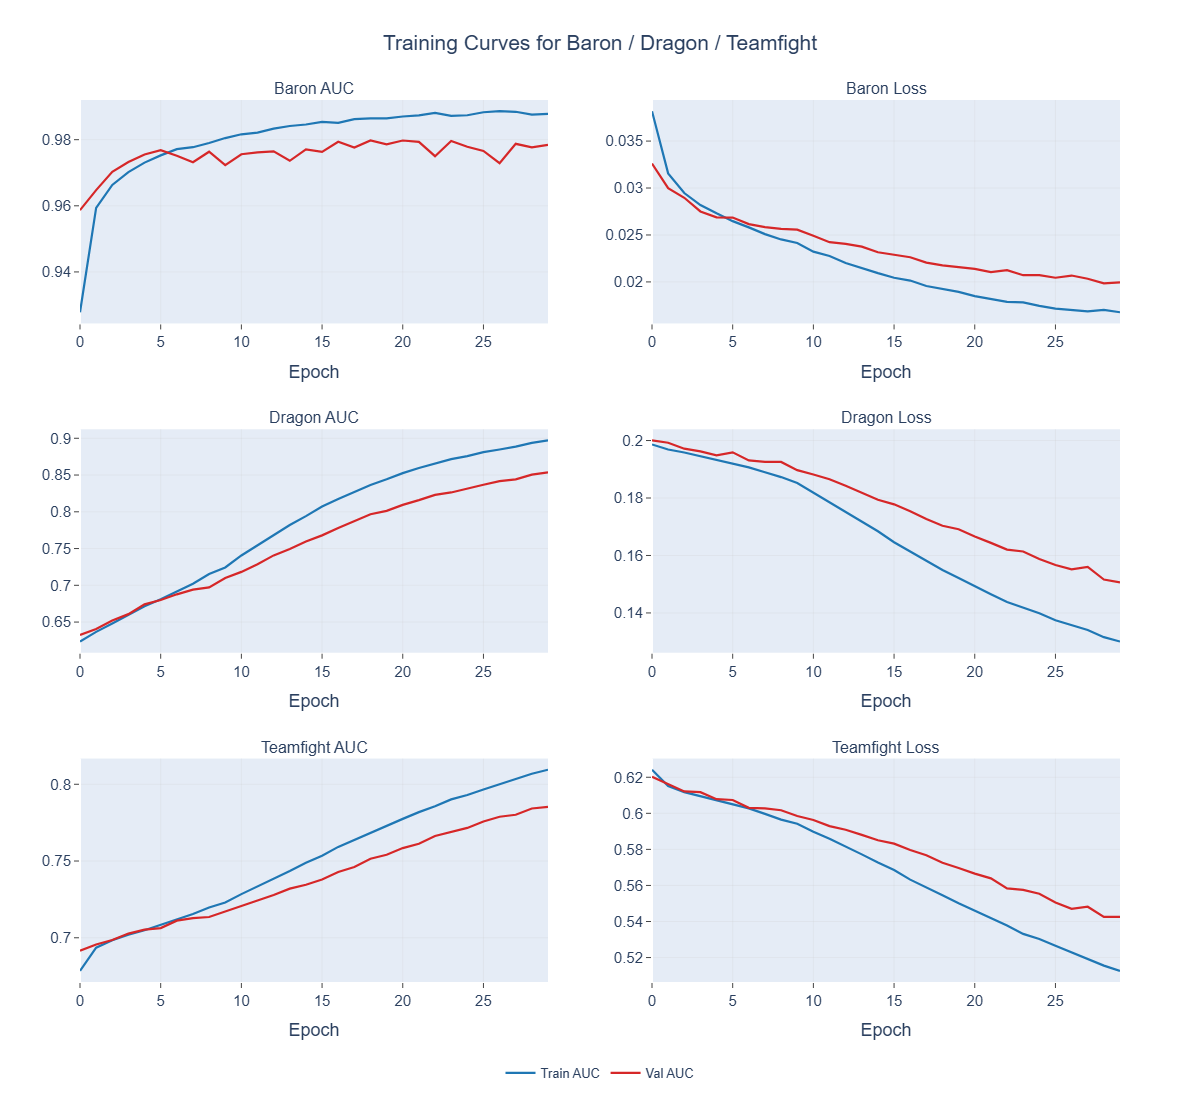

# **Confusion Matrix**

In [20]:
from sklearn.metrics import confusion_matrix
import plotly.express as px
def plot_cm(y_true, y_pred, name):
    thr = tune_threshold(y_true, y_pred)
    yt = y_true.flatten().astype(int)
    yp = (y_pred >= thr).astype(int).flatten()
    cm = confusion_matrix(yt, yp)
    fig = px.imshow(cm, text_auto=True, color_continuous_scale="Blues", labels=dict(x="Predicted", y="True", color="Count"),
                    title=f"{name} Confusion Matrix<br>(threshold={thr:.3f})")
    fig.update_layout(width=400, height=400)
    fig.show()
plot_cm(baron_true, baron_pred, "Baron")
plot_cm(dragon_true, dragon_pred, "Dragon")
plot_cm(teamfight_true, teamfight_pred, "Teamfight")

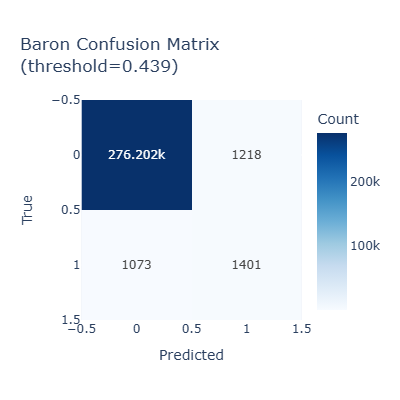

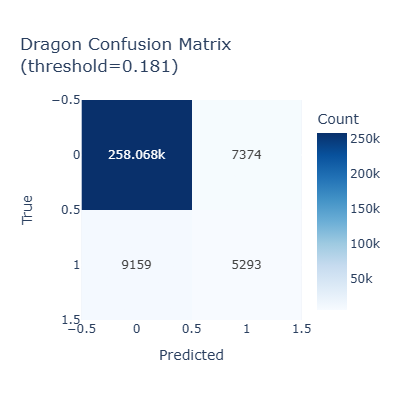

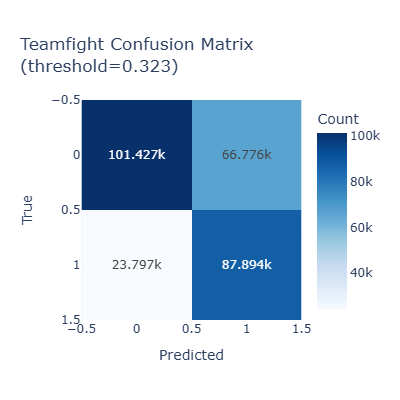